# Icecream Sales Forecasting

1. This notebook demonstrates BigLake firegrained permissions
2. The dataset is the free [Kaggle Icecream Revenue](https://www.kaggle.com/vinicius150987/ice-cream-revenue) dataset 
3. A precreated BigLake table is backed by the Kaggle CSV file in Cloud Storage, and is secured with column-level security and row level security
4. The notebook first demonstrates PySpark, powered by Cloud Dataproc (personal auth cluster) to cleanse & transform data
5. It then forecasts revenue with Prophet (plain Python, not Spark)

### 1. Imports

In [1]:
import pandas as pd
from prophet import Prophet
from pyspark.sql.functions import month, date_format
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')

### 2. Create a Spark session powered by Cloud Dataproc 

In [2]:
spark = SparkSession.builder.appName('Icecream Sales Analysis').getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/25 15:53:43 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/25 15:53:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/25 15:53:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/25 15:53:43 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


### 3. Read the BigLake table IceCreamSales via PySpark and the Spark BigQuery Connector

In [3]:
project_id_output = !gcloud config list --format "value(core.project)" 2>/dev/null
PROJECT_ID = project_id_output[0]
print("PROJECT_ID: ", PROJECT_ID)

PROJECT_ID:  ts22-lab


In [4]:
project_name_output = !gcloud projects describe $PROJECT_ID | grep name | cut -d':' -f2 | xargs
PROJECT_NAME = project_name_output[0]
print("PROJECT_NAME: ", PROJECT_NAME)

PROJECT_NAME:  ts22-lab


In [5]:
rawDF = spark.read \
  .format("bigquery") \
  .load(f"{PROJECT_NAME}.ts22_tf_lab_ds.icecream_sales_biglake_table") 

### 4. Explore the raw IceCreamSales data

In [6]:
rawDF.show(10)

+---------+----------+-------------+--------+-----------+
|  country|     month|Gross_Revenue|Discount|Net_Revenue|
+---------+----------+-------------+--------+-----------+
|Australia|2022-08-15|     199346.7|    39.0|  121601.49|
|Australia|2022-07-15|    180936.88|    38.0|  112180.87|
|Australia|2022-06-15|    201337.86|    38.0|  124829.47|
|Australia|2022-05-15|    203299.48|    39.0|  124012.68|
|Australia|2022-04-15|    260978.92|    40.0|  156587.35|
|Australia|2022-03-15|    290328.95|    39.0|  177100.66|
|Australia|2022-02-15|    299798.91|    39.0|  182877.33|
|Australia|2022-01-15|    298864.95|    40.0|  179318.97|
|Australia|2021-12-15|     286137.3|    39.0|  174543.75|
|Australia|2021-11-15|    253991.97|    40.0|  152395.18|
+---------+----------+-------------+--------+-----------+
only showing top 10 rows



In [9]:
rawDF.createOrReplaceTempView("icecream_sales")

In [8]:
# Count total rows
spark.sql("select count(*) as row_count from icecream_sales").show()

+---------+
|row_count|
+---------+
|     3497|
+---------+



In [10]:
# Date range of historical sales data
spark.sql("select min(month) date_range_start, max(month) date_range_end from icecream_sales").show()

+----------------+--------------+
|date_range_start|date_range_end|
+----------------+--------------+
|      2019-06-15|    2022-08-15|
+----------------+--------------+



In [ ]:
# Countries listing
spark.sql("select distinct country from icecream_sales").show()

In [ ]:
# Row count by country
spark.sql("select country, count(*) as row_count from icecream_sales group by country").show()

In [ ]:
# Data for Australia
spark.sql("select * from icecream_sales where country='Australia' limit 10").show()

In [ ]:
# Data for United States
spark.sql("select * from icecream_sales where country='United States' limit 10").show()

### 5. Subset and format the data, in preparation for forecasting

In [11]:
cleanedDF = rawDF.select(date_format('Month', 'MM/yyyy').alias('ds'),"gross_revenue").withColumn("revenue", rawDF["Gross_Revenue"].cast(IntegerType()))
cleanedDF.show(10)

+-------+-------------+-------+
|     ds|gross_revenue|revenue|
+-------+-------------+-------+
|08/2022|     199346.7| 199346|
|07/2022|    180936.88| 180936|
|06/2022|    201337.86| 201337|
|05/2022|    203299.48| 203299|
|04/2022|    260978.92| 260978|
|03/2022|    290328.95| 290328|
|02/2022|    299798.91| 299798|
|01/2022|    298864.95| 298864|
|12/2021|     286137.3| 286137|
|11/2021|    253991.97| 253991|
+-------+-------------+-------+
only showing top 10 rows



### 6. Aggregate the data, in preparation for forecasting

In [12]:
groupedDF = cleanedDF.groupBy('ds').sum("Revenue").withColumnRenamed("sum(Revenue)", "y")
groupedDF.show(10)

+-------+---------+
|     ds|        y|
+-------+---------+
|10/2021| 60847282|
|04/2020| 60016829|
|05/2021| 65522883|
|09/2021| 86777946|
|07/2019|106939238|
|05/2020| 65484985|
|05/2022| 77150025|
|04/2022| 48472239|
|03/2021| 45362493|
|06/2020| 74350561|
+-------+---------+
only showing top 10 rows



### 7. Convert the aggregated "small" data to a Pandas dataframe for forecasting with Prophet

In [13]:
historyPDF = groupedDF.toPandas()

### 8. Instantiate a model

In [14]:
model = Prophet(
    interval_width=0.90
)

### 9. Fit the model with the Pandas dataframe of aggregated revenue by month and year

In [15]:
model.fit(historyPDF)

15:56:07 - cmdstanpy - INFO - Chain [1] start processing
15:56:07 - cmdstanpy - INFO - Chain [1] done processing


### 10. Create a Prophet future dataframe 

In [16]:
futureDatePDF = model.make_future_dataframe(
    periods=6,
    freq='m',
    include_history=True
)

### 11. Forecast future sales

In [17]:
forecastPDF = model.predict(futureDatePDF)

### 12. Review the predictions

In [18]:
forecastPDF[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
40,2022-09-30,6.831464e+07,6.165321e+07,7.480325e+07
41,2022-10-31,5.352092e+07,4.671633e+07,6.002955e+07
42,2022-11-30,4.901628e+07,4.260265e+07,5.582173e+07
43,2022-12-31,6.044963e+07,5.381307e+07,6.671665e+07
44,2023-01-31,6.708975e+07,6.069109e+07,7.353542e+07


### 13. Plot the sales

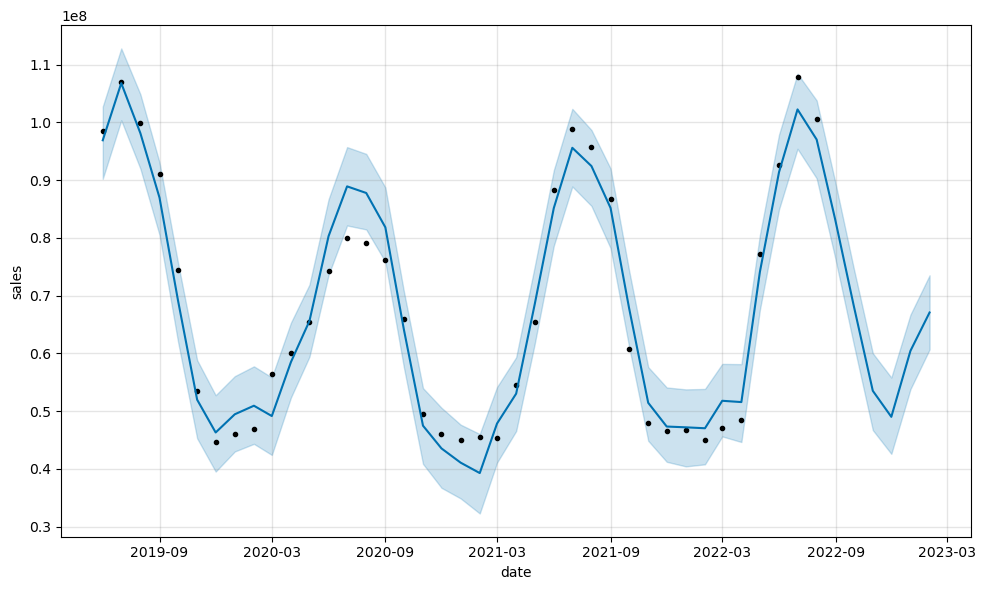

In [19]:
predictionPlot = model.plot(forecastPDF, xlabel='date', ylabel='sales')